In [1]:
using Gen
using Random
using CairoMakie
using Distributions
using StatsBase

#### Helper functions

In [2]:
const Card = Union{Symbol, Int}
const State = Tuple{Int, Card, Bool}
const Policy = Dict{State, Float64}

CARD_MAP = [:ace, :two, :three, :four, :five, :six, :seven, :eight, :nine, :ten, :jack, :queen, :king]

function sort_hand(hand)
    # aces should be last
    return sort(hand, lt=(x,y) -> x != :ace)
end

function get_value(card, sum_so_far)
    if card == :ace
        if sum_so_far + 11 <= 21
            return 11
        else
            return 1
        end
    elseif card == :jack || card == :queen || card == :king
        return 10
    else
        # get index in card map
        return findfirst(x -> x == card, CARD_MAP)
    end
end

function get_sum(hand)
    hand = sort_hand(hand)
    sum = 0
    for card in hand
        sum += get_value(card, sum)
    end
    return sum
end

function holds_usable_ace(hand)
    hand = sort_hand(hand)
    sum = 0
    for card in hand
        value = get_value(card, sum)    
        if value == 11
            return true
        end
        sum += value
    end
    return false
end

function states()
    states = []
    for i in 4:21
        for j in 1:13
            for k in [true, false]
                push!(states, (i, CARD_MAP[j], k))
            end
        end
    end
    return states
end

STATES = states();

function plot_policy(policy::Policy)
    
    # Define ranges for player sums and dealer showing cards
    player_sums = 12:21  # x-axis
    dealer_showing = 1:13  # y-axis

    # Initialize z-values based on the policy
    z_true = zeros(Float64, length(player_sums), length(dealer_showing))
    z_false = zeros(Float64, length(player_sums), length(dealer_showing))

    # Populate z-values based on the policy
    for i in player_sums
        for j in dealer_showing
            card = CARD_MAP[j]
            z_true[i - 11, j] = policy[(i, card, true)]
            z_false[i - 11, j] = policy[(i, card, false)]
        end
    end

    # Create figure
    fig = Figure(resolution = (800, 600))

    # Surface plot with usable ace
    ax1 = Axis3(fig[1, 1], title = "Usable Ace")
    surface!(ax1, player_sums, dealer_showing, z_true)
    ax1.xlabel = "Player sum"
    ax1.ylabel = "Dealer showing"
    ax1.zlabel = "1 = Hit, 0 = Stick"

    # Surface plot without usable ace
    ax2 = Axis3(fig[1, 2], title = "No Usable Ace")
    surface!(ax2, player_sums, dealer_showing, z_false)
    ax2.xlabel = "Player sum"
    ax2.ylabel = "Dealer showing"
    ax2.zlabel = "1 = Hit, 0 = Stick"

    # Display the figure
    display(fig)
end

function most_frequent_policy(dict_list::Vector{Policy})
    # Dictionary to count occurrences of each dictionary
    dict_counts = Dict{Policy, Int}()
    
    for d in dict_list
        # Increment count for each dictionary
        dict_counts[d] = get(dict_counts, d, 0) + 1
    end
    
    # Find the dictionary with the maximum count
    most_frequent = argmax(dict_counts)
    
    return most_frequent, dict_counts[most_frequent]  # Return the most frequent dict and its count
end

function plot_mode_policy(traces)

    most_frequent, count = most_frequent_policy([get_retval(trace) for trace in traces])

    println("Most frequent policy occurred $count times")

    plot_policy(most_frequent)
end;

function plot_mean_policy(traces)
    mean_pol = Policy()
    for state in STATES 
        mean_pol[state] = mean([run[:policy => state] for run in traces])
    end

    plot_policy(mean_pol)
end;


#### Helper distributions

In [3]:
@dist function draw_card()
    card = uniform_discrete(1,13)
    CARD_MAP[card]
end;


#### Model

In [4]:
@gen function blackjack_model(policy::Dict{State, Float64})
    sum = 0
    
    # initialize actions
    actions = Dict{State, Int}()
    for state in STATES
        actions[state] = {:action => state} ~ bernoulli(policy[state])
    end

    # Player
    card1 = {:card => 1} ~ draw_card()
    card2 = {:card => 2} ~ draw_card()
    hand = [card1, card2]

    # Dealer
    dealer_first_card = {:dealer => 1} ~ draw_card()
    dealer_visible_card = {:dealer => 2} ~ draw_card()

    sum = get_sum(hand)
    state = (sum, dealer_visible_card, holds_usable_ace(hand))

    playing = true
    # Player's turn
    for i in 3:11 
        card = {:card => i} ~ draw_card()
        if playing && actions[state] == 1
            push!(hand, card)
            sum = get_sum(hand)
            state = (sum, dealer_visible_card, holds_usable_ace(hand))
            if sum > 21
                playing = false
            end
        else
            playing = false
        end
    end

    # Dealer's turn
    dealer_hand = [dealer_first_card, dealer_visible_card]
    dealer_sum = get_sum(dealer_hand)
    playing = true
    for i in 3:11
        card = {:dealer => i} ~ draw_card()
        if playing
            push!(dealer_hand, card)
            dealer_sum = get_sum(dealer_hand)
            if dealer_sum >= 17
                playing = false
            end
        end
    end
    
    # Determine winner
    if sum > 21
        return 1
    elseif dealer_sum > 21
        return 100
    elseif sum > dealer_sum
        return 100
    elseif sum < dealer_sum
        return 1
    else
        return 50
    end

end;

In [5]:
policy = Dict{State, Float64}()
for state in STATES
    policy[state] = 0.5
end


trace = simulate(blackjack_model, (policy,))
get_retval(trace)

1

### Policy search with Prior

In [6]:
@gen function policy_select()
    policy = Dict{State, Float64}()
    for state in STATES
        if state[1] >= 15
            policy[state] = {:policy => state} ~ beta(1,2)
        else
            policy[state] = {:policy => state} ~ beta(1,1)
        end
    end

    # play one game according to this policy
    ret = {:ret} ~ blackjack_model(policy)

    # ret is either 1, 50 or 100 --> transform to Bernoulli
    p = ret / 100 # max reward = 100

    o ~ bernoulli(p)
    
    return policy
end;

Sampling from policy_select conditional on o = 1 will produce a marginal distribution on policies that is proportional to their expected return.

--> only need to sample from the conditional and pick the policy that occurs most frequently

In [7]:
trace = simulate(policy_select, ())

# plot_policy(get_retval(trace))

Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##policy_select#226", Bool[], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(:o => Gen.ChoiceOrCallRecord{Bool}(true, 0.0, NaN, true), :ret => Gen.ChoiceOrCallRecord{Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}}(Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Dict{Tuple{Int64, Union{Int64, Symbol}, Bool}, Float64}], false, Union{Nothing, Some{Any}}[nothing], var"##blackjack_model#225", Bool[0], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(), Dict{Any, Trie{Any, Gen.ChoiceOrCallRecord}}(:dealer => Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(5 => Gen.ChoiceOrCallRecord{Symbol}(:eight, -2.5649493574615367, NaN, true), 8 => Gen.ChoiceOrCallRecord{Symbol}(:queen, -2.5649493574615367, N

#### Rejection Sampling

In [8]:
conditioned = []
for i in 1:1e4
    run = simulate(policy_select, ())
    if run[:o] == 1
        push!(conditioned, run)
    end
end
length(conditioned)

4914

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/gG38B/src/scenes.jl:227


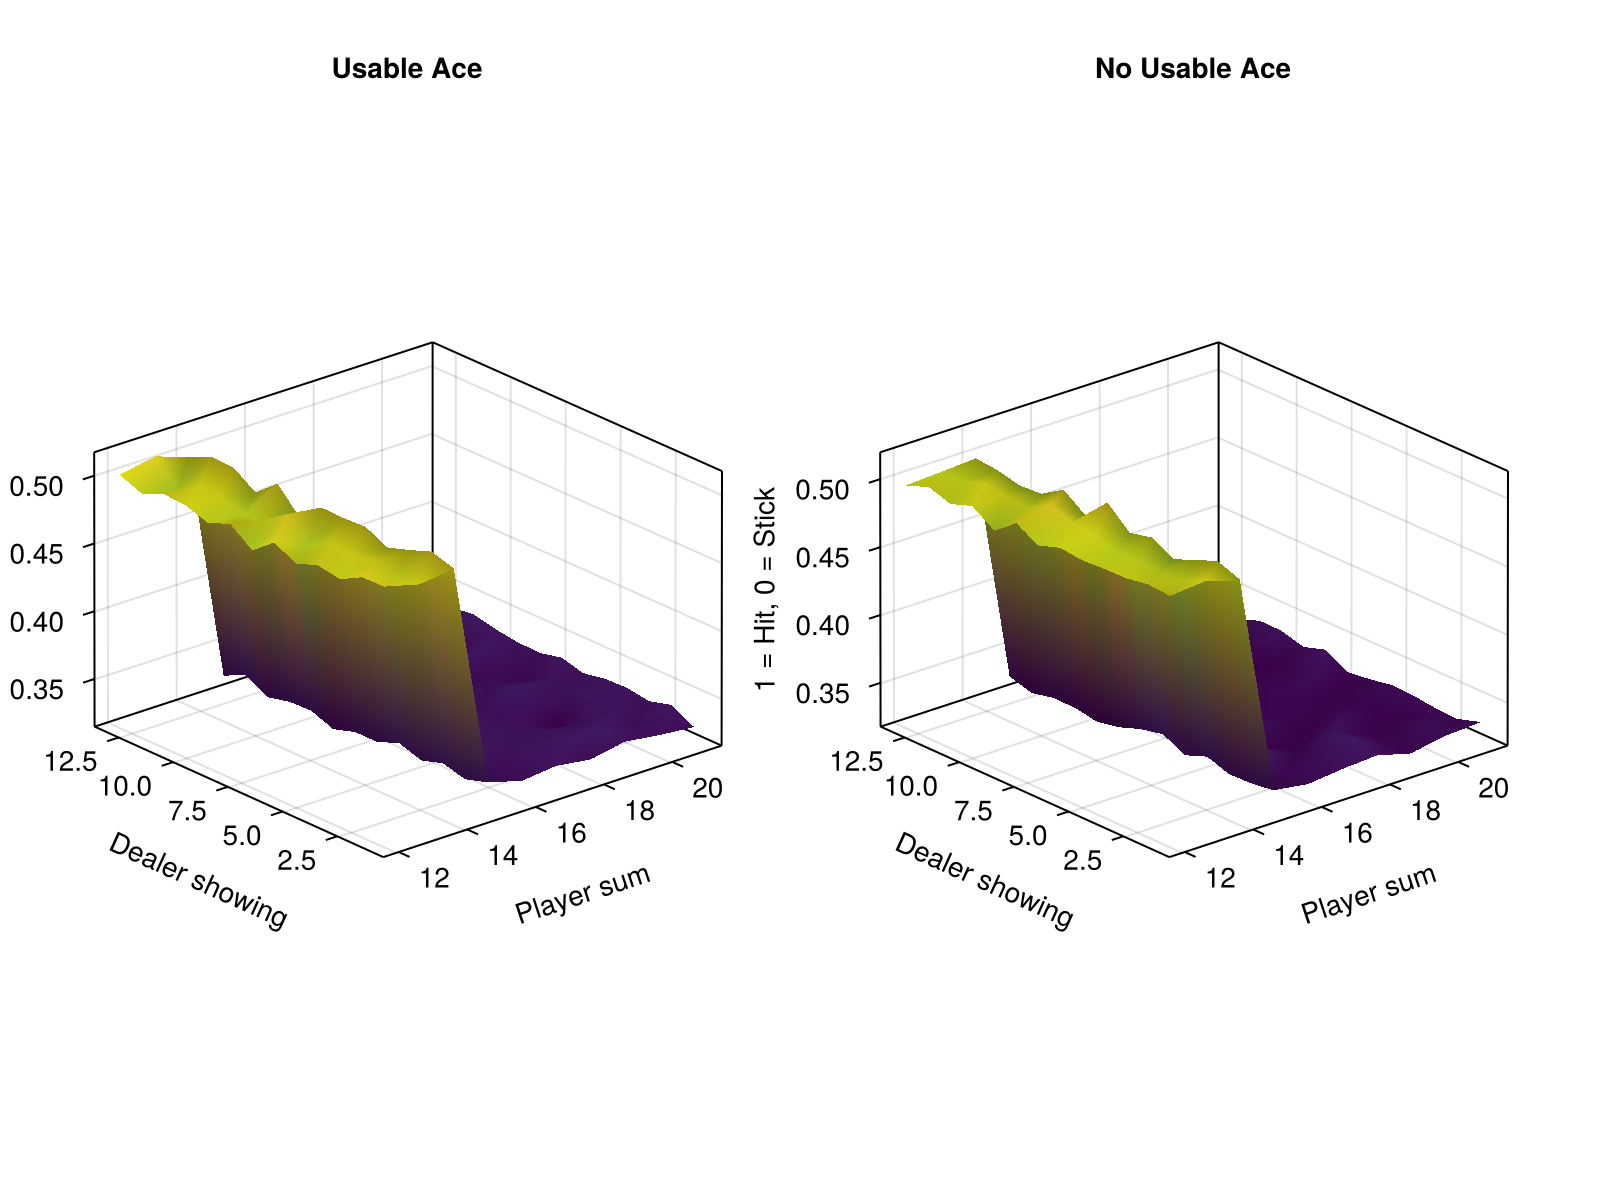

CairoMakie.Screen{IMAGE}


In [9]:
plot_mean_policy(conditioned)


### MCMC

In [10]:
@gen function proposal(curr_trace, state, kappa)
    curr_val = curr_trace[:policy => state]
    α = curr_val * kappa
    β = (1 - curr_val) * kappa
    policy = {:policy => state} ~ beta(α, β)
end

function block_update(trace)
    # update policy
    for s in STATES
        (trace,_) = mh(trace, Gen.select(:policy => s)) 
        (trace,_) = mh(trace, Gen.select(:ret => :action => s)) 
    end

    for t in 1:11
        (trace,_) = mh(trace, Gen.select(:ret => :card => t))
        (trace,_) = mh(trace, Gen.select(:ret => :dealer => t))
    end
    
    return trace
end
function drift_update(trace)
    # update policy
    for s in STATES
        (trace,_) = mh(trace, proposal, (s, 1)) 
        (trace,_) = mh(trace, Gen.select(:ret => :action => s)) 
    end

    for t in 1:11
        (trace,_) = mh(trace, Gen.select(:ret => :card => t))
        (trace,_) = mh(trace, Gen.select(:ret => :dealer => t))
    end
    
    return trace
end

drift_update (generic function with 1 method)

In [11]:
(trace,_) = generate(policy_select,(), choicemap((:o,1)))

# trace[:policy => (20, :king, false)]
# trace[:ret => :action => (20, :king, false)]
# trace[:ret => :dealer => 11]

# get_retval(trace)

traces = [trace]
for _ in 1:1e3
    trace = block_update(trace)
    push!(traces,trace)
end
traces

1001-element Vector{Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}}:
 Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##policy_select#226", Bool[], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(:o => Gen.ChoiceOrCallRecord{Bool}(true, 0.0, NaN, true), :ret => Gen.ChoiceOrCallRecord{Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}}(Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Dict{Tuple{Int64, Union{Int64, Symbol}, Bool}, Float64}], false, Union{Nothing, Some{Any}}[nothing], var"##blackjack_model#225", Bool[0], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(), Dict{Any, Trie{Any, Gen.ChoiceOrCallRecord}}(:dealer => Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(5 => Gen.ChoiceOrCallRecord{Symbol}(:five, -2.5649493574615367, NaN, true),

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/gG38B/src/scenes.jl:227


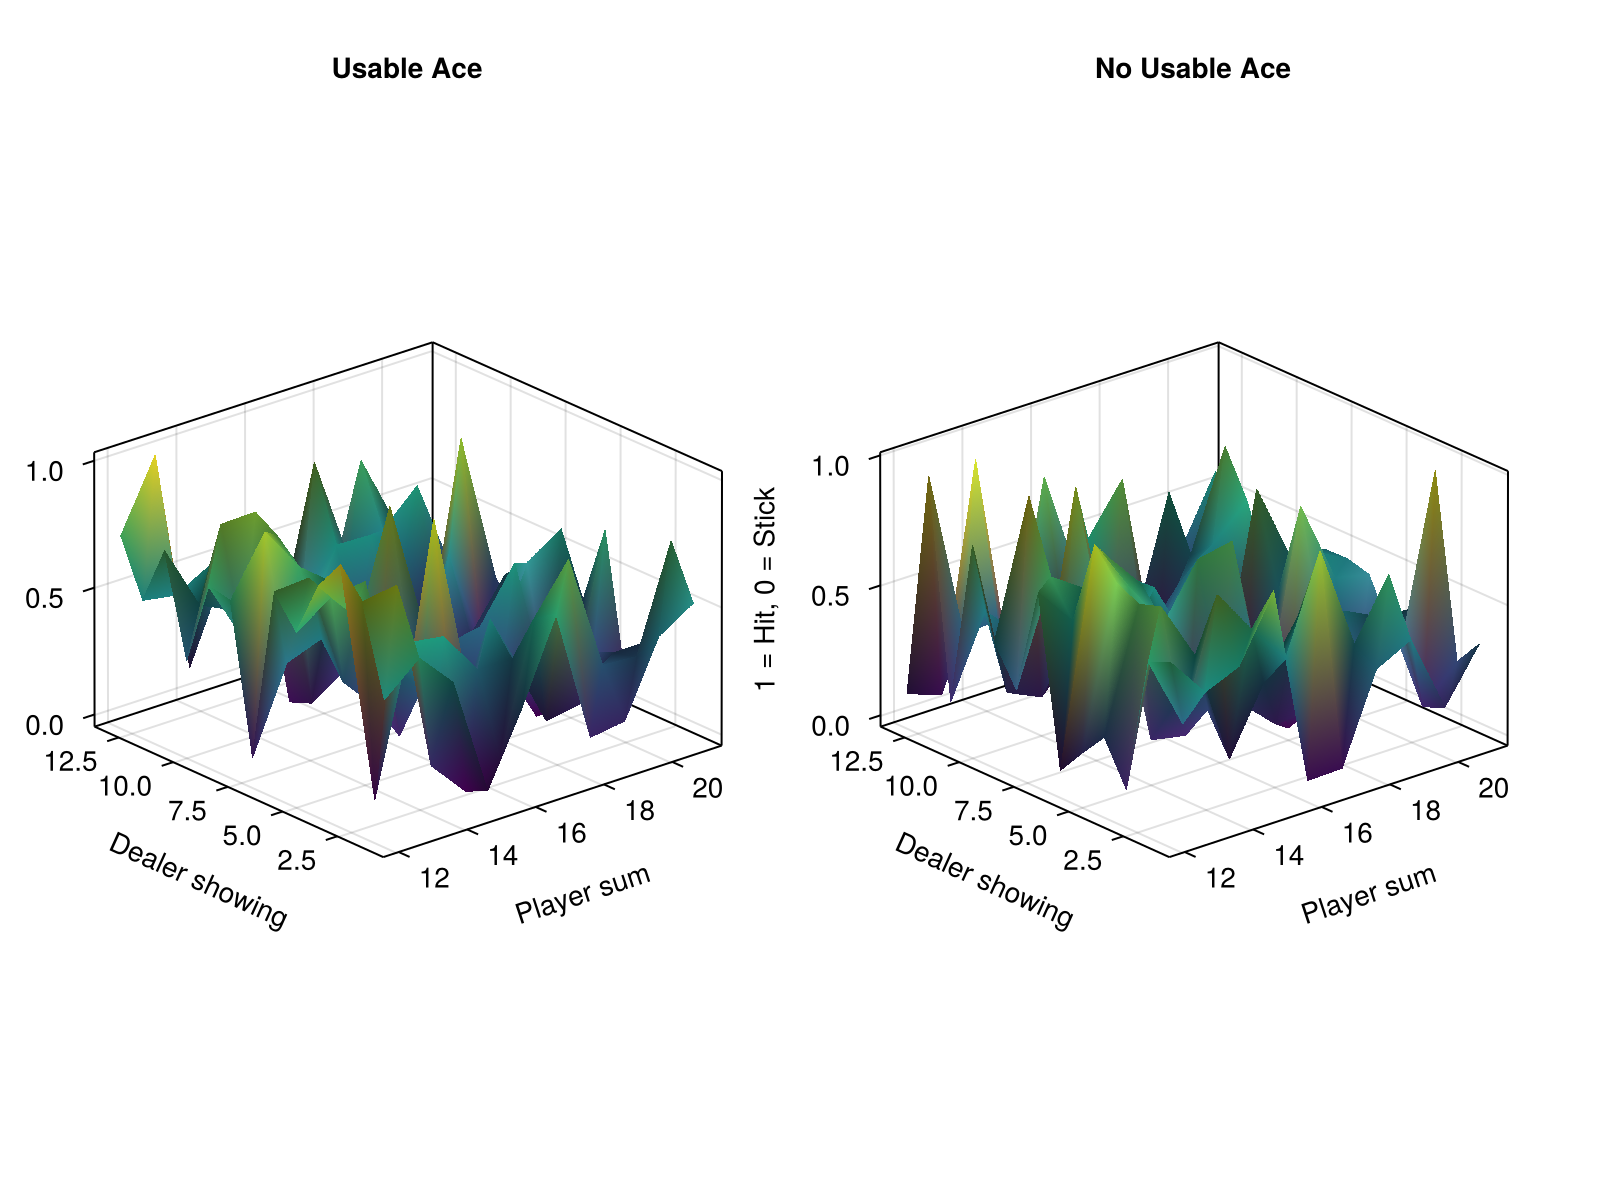

CairoMakie.Screen{IMAGE}


In [12]:
plot_policy(get_retval(traces[end]))

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/gG38B/src/scenes.jl:227


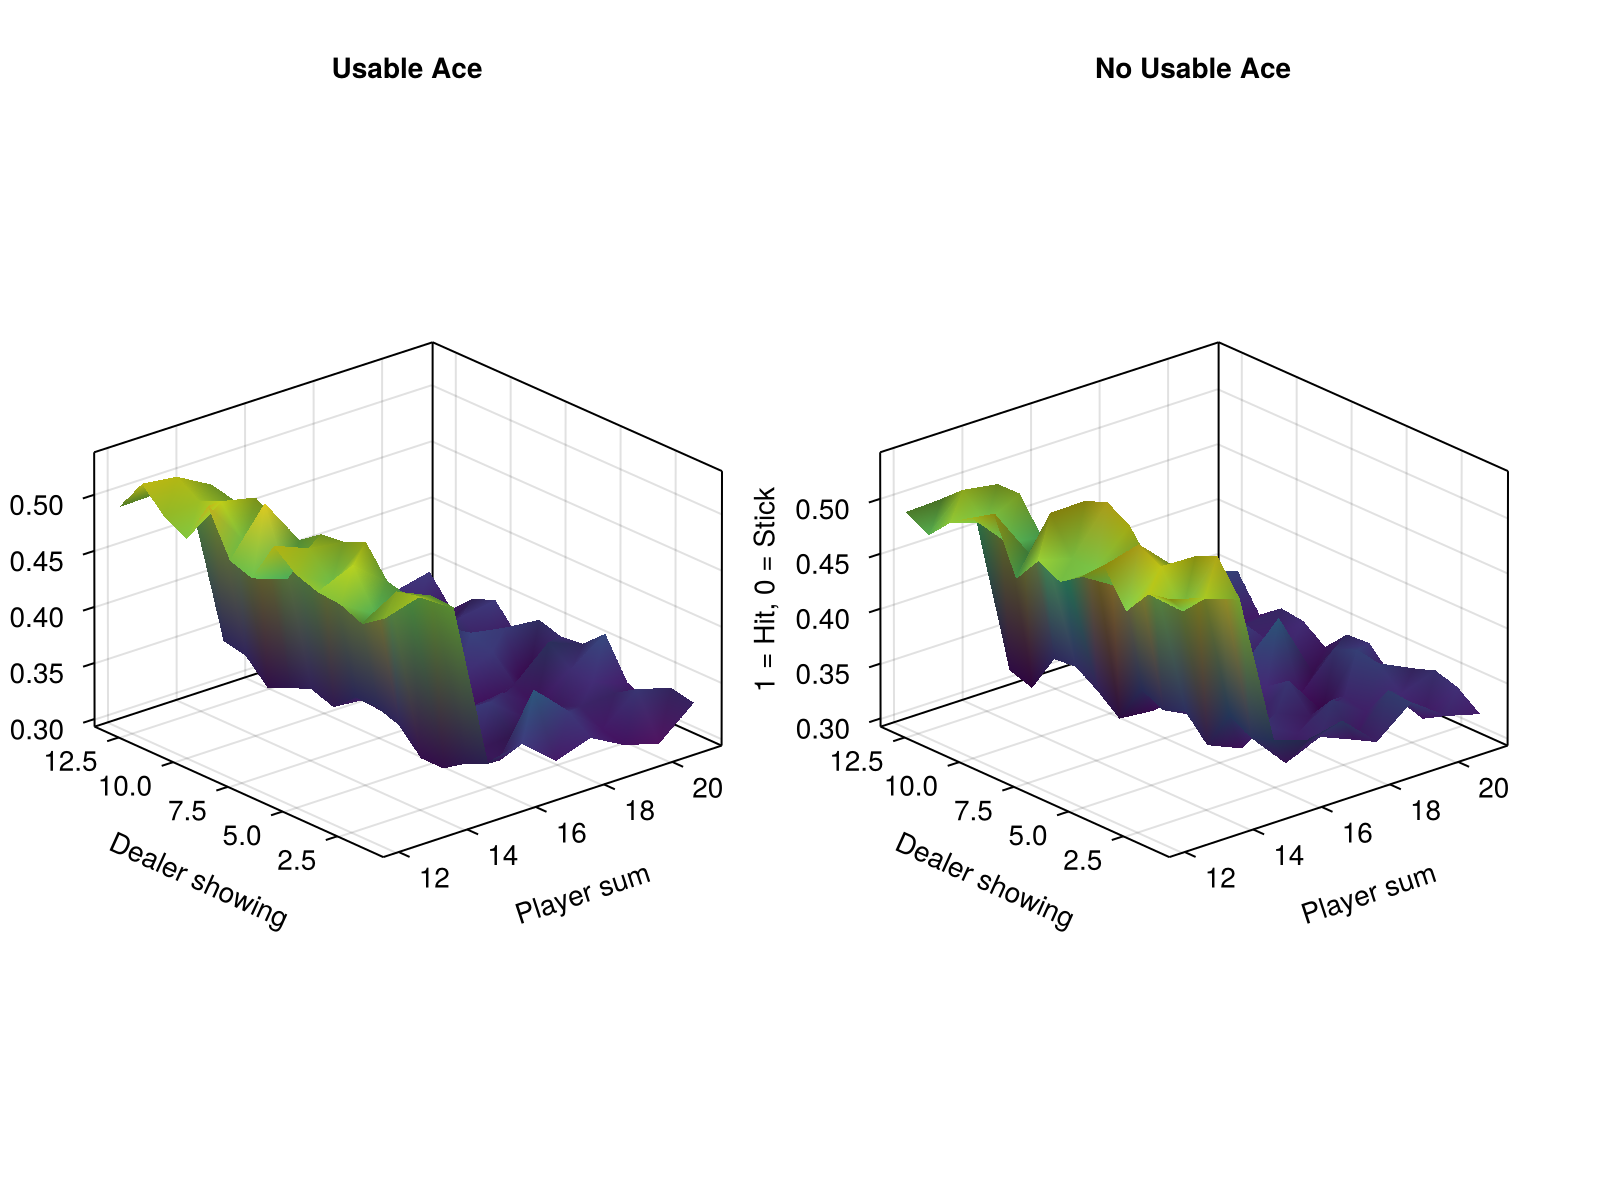

CairoMakie.Screen{IMAGE}


In [13]:
plot_mean_policy(traces)

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/gG38B/src/scenes.jl:227


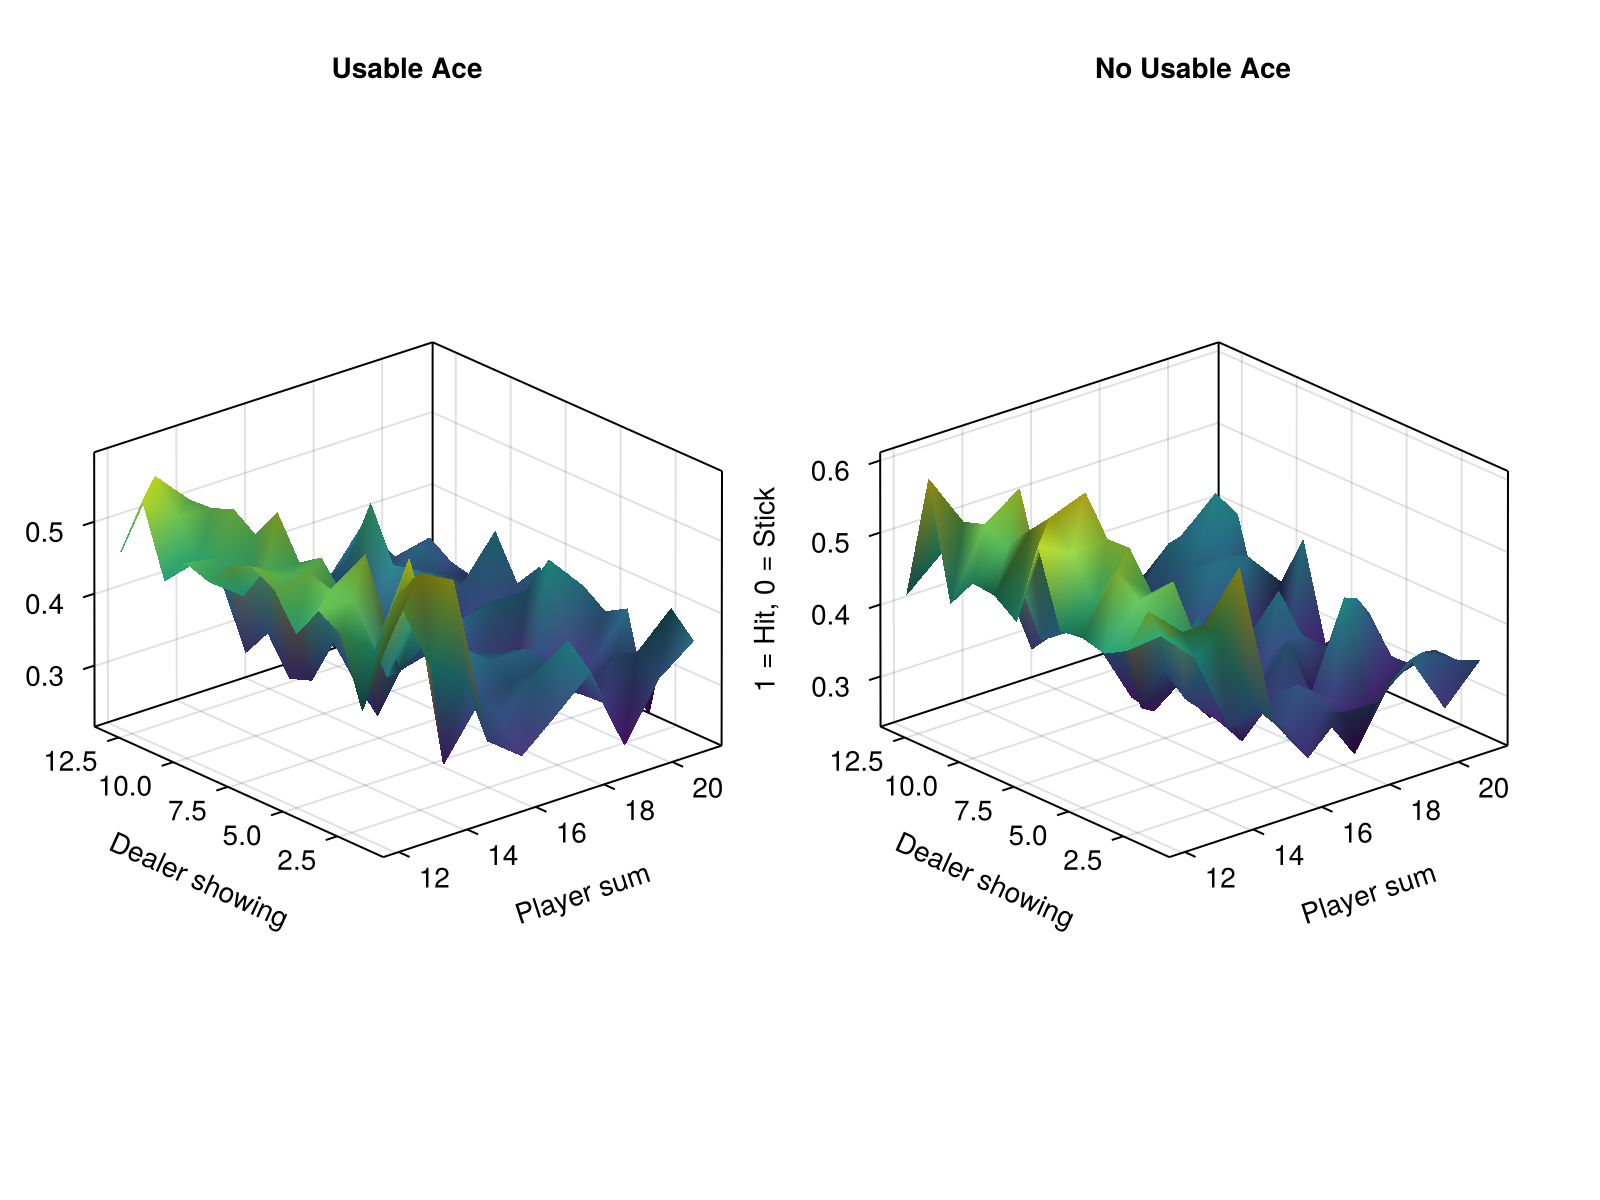

CairoMakie.Screen{IMAGE}


In [14]:
plot_mean_policy(traces[end-100:end])

## Policy search with uniform prior

In [15]:
@gen function policy_select_uniform()
    policy = Dict{State, Float64}()
    for state in STATES
        policy[state] = {:policy => state} ~ beta(1,1)
    end

    # play one game according to this policy
    ret = {:ret} ~ blackjack_model(policy)

    # ret is either 1, 50 or 100 --> transform to Bernoulli
    p = ret / 100 # max reward = 100

    o ~ bernoulli(p)
    
    return policy
end;

In [ ]:
conditioned = []
for i in 1:1e4
    run = simulate(policy_select_uniform, ())
    if run[:o] == 1
        push!(conditioned, run)
    end
end
length(conditioned)

In [ ]:
plot_mean_policy(conditioned)

In [16]:
(trace,_) = generate(policy_select_uniform,(), choicemap((:o,1)))

traces = [trace]
for _ in 1:1e3
    trace = drift_update(trace)
    push!(traces,trace)
end

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/gG38B/src/scenes.jl:227


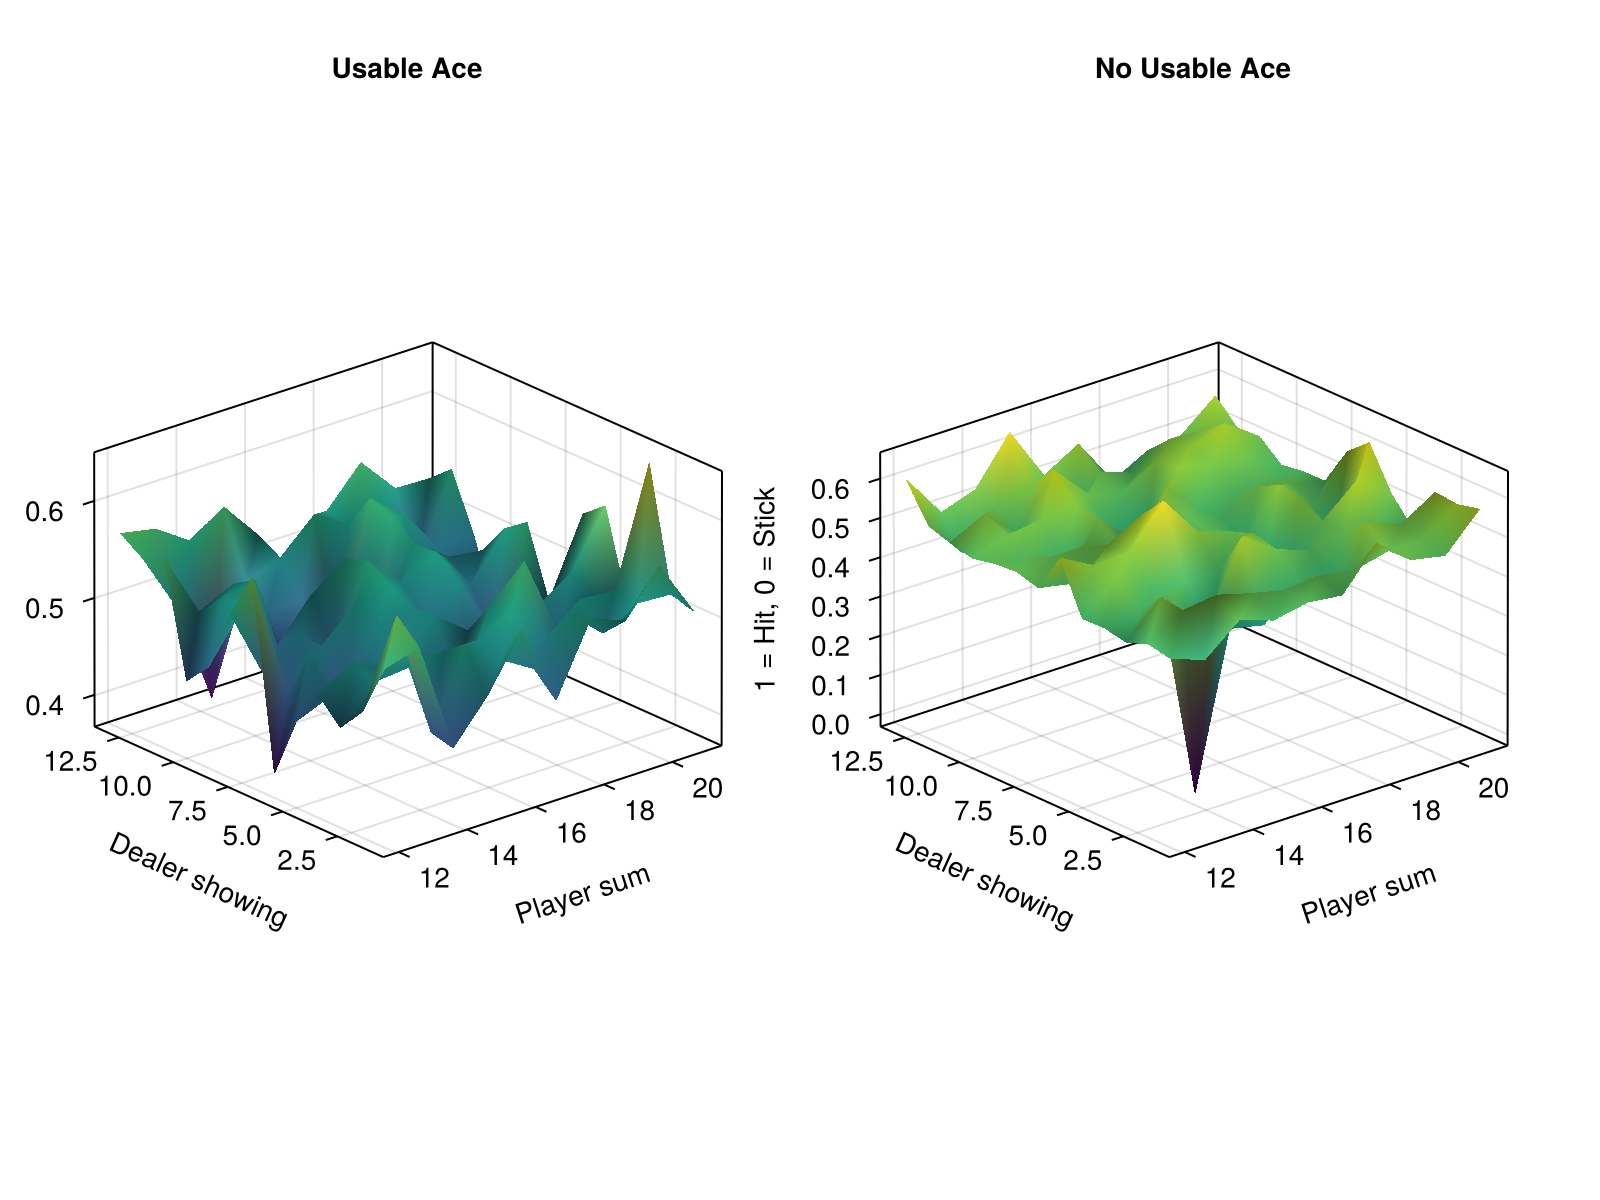

CairoMakie.Screen{IMAGE}


In [17]:
plot_mean_policy(traces)

# Stronger rewards

In [18]:
@gen function blackjack_model_1000(policy::Dict{State, Float64})
    sum = 0
    
    # initialize actions
    actions = Dict{State, Int}()
    for state in STATES
        actions[state] = {:action => state} ~ bernoulli(policy[state])
    end

    # Player
    card1 = {:card => 1} ~ draw_card()
    card2 = {:card => 2} ~ draw_card()
    hand = [card1, card2]

    # Dealer
    dealer_first_card = {:dealer => 1} ~ draw_card()
    dealer_visible_card = {:dealer => 2} ~ draw_card()

    sum = get_sum(hand)
    state = (sum, dealer_visible_card, holds_usable_ace(hand))

    playing = true
    # Player's turn
    for i in 3:11 
        card = {:card => i} ~ draw_card()
        if playing && actions[state] == 1
            push!(hand, card)
            sum = get_sum(hand)
            state = (sum, dealer_visible_card, holds_usable_ace(hand))
            if sum > 21
                playing = false
            end
        else
            playing = false
        end
    end

    # Dealer's turn
    dealer_hand = [dealer_first_card, dealer_visible_card]
    dealer_sum = get_sum(dealer_hand)
    playing = true
    for i in 3:11
        card = {:dealer => i} ~ draw_card()
        if playing
            push!(dealer_hand, card)
            dealer_sum = get_sum(dealer_hand)
            if dealer_sum >= 17
                playing = false
            end
        end
    end
    
    # Determine winner
    if sum > 21
        return 1
    elseif dealer_sum > 21
        return 1000
    elseif sum > dealer_sum
        return 1000
    elseif sum < dealer_sum
        return 1
    else
        return 500
    end

end;

In [19]:
@gen function policy_select_uniform_1000()
    policy = Dict{State, Float64}()
    for state in STATES
        policy[state] = {:policy => state} ~ beta(1,1)
    end

    # play one game according to this policy
    ret = {:ret} ~ blackjack_model_1000(policy)

    # ret is either 1, 500 or 1000 --> transform to Bernoulli
    p = ret / 1000 # max reward = 1000

    o ~ bernoulli(p)
    
    return policy
end;

In [20]:
(trace,_) = generate(policy_select_uniform_1000,(), choicemap((:o,1)))

traces = [trace]
for _ in 1:1e3
    trace = drift_update(trace)
    push!(traces,trace)
end

LoadError: InterruptException:

In [ ]:
plot_mean_policy(traces[end-100:end])

## Longer Episodes

In [21]:
@gen function policy_select_uniform_long_ep()
    policy = Dict{State, Float64}()
    for state in STATES
        policy[state] = {:policy => state} ~ beta(1,1)
    end

    # play 1000 games according to this policy
    for i in 1:1e3
        ret = {:ret => i} ~ blackjack_model_1000(policy)
    end

    # ret is either 1, 500 or 1000 --> transform to Bernoulli
    p = ret / 1000 # max reward = 1000

    o ~ bernoulli(p)
    
    return policy
end;

In [22]:
(trace,_) = generate(policy_select_uniform_1000,(), choicemap((:o,1)))

traces = [trace]
for _ in 1:1e2
    trace = drift_update(trace)
    push!(traces,trace)
end

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/gG38B/src/scenes.jl:227


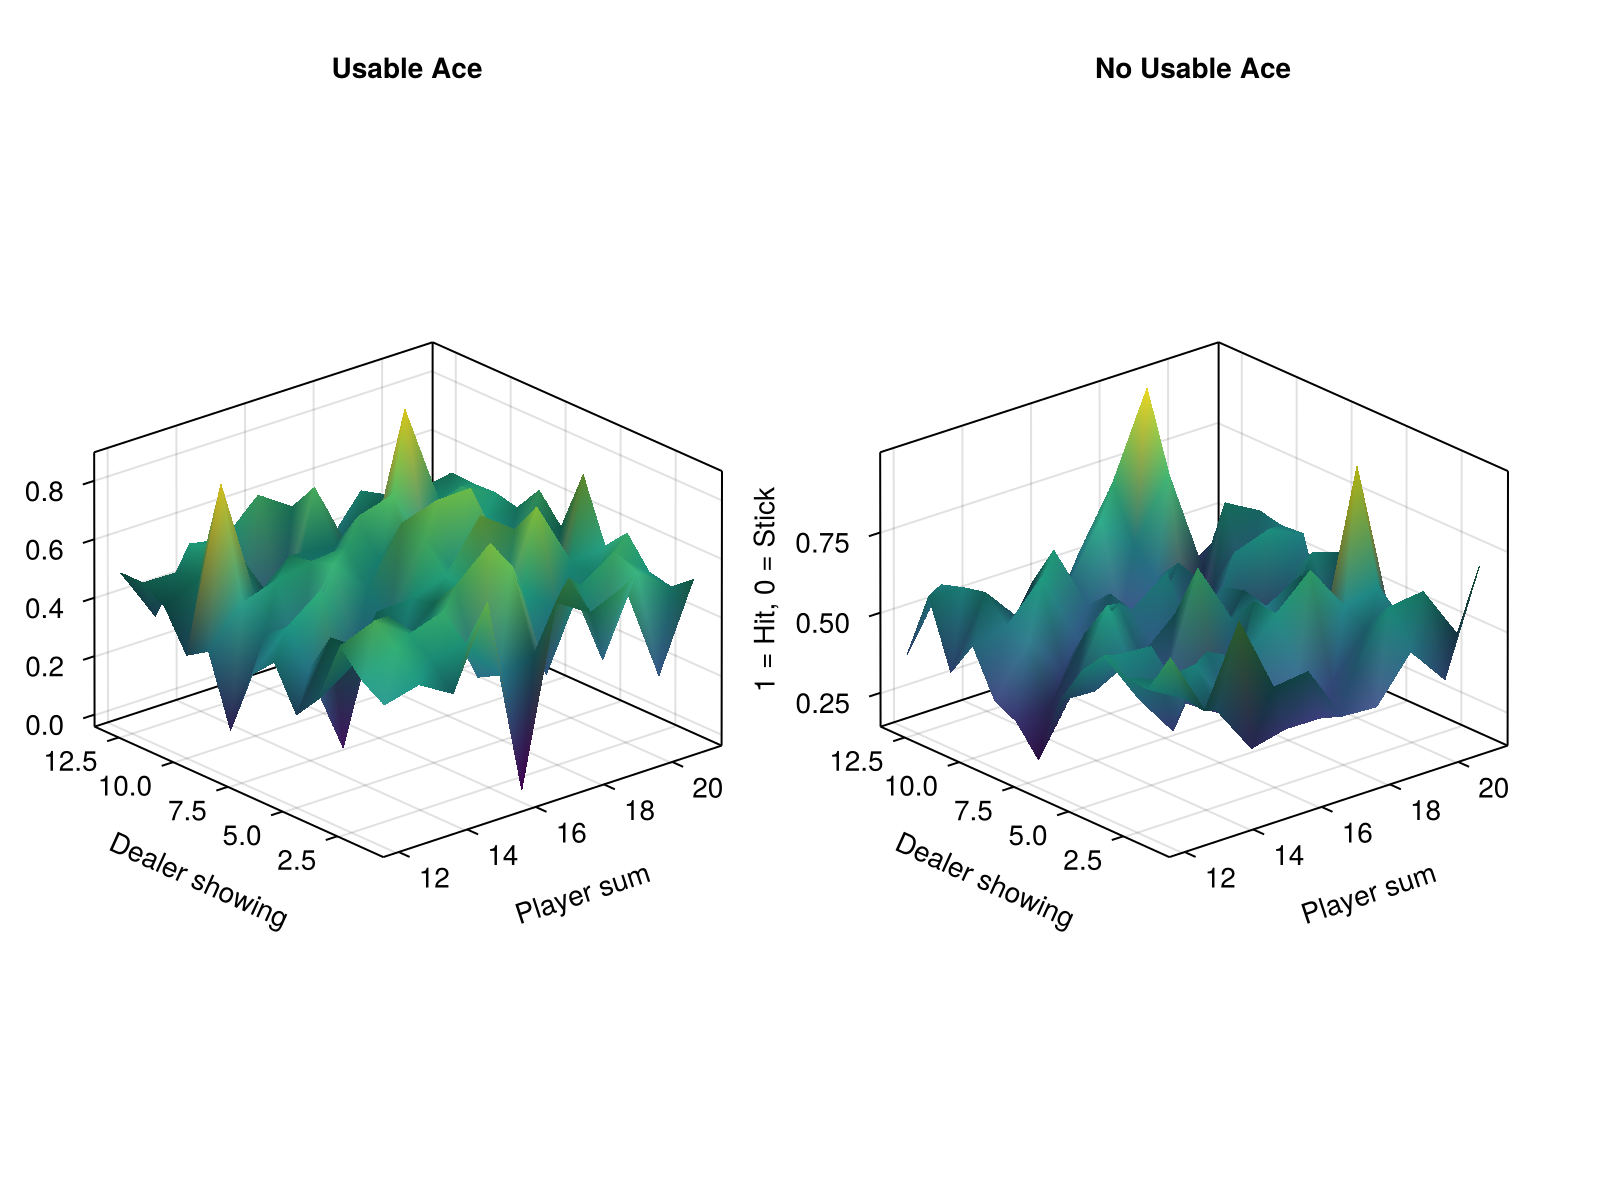

CairoMakie.Screen{IMAGE}


In [23]:
plot_mean_policy(traces[end-100:end])